# MITGCM Scale Analysis 

**Purpose**: Code for preforming the time scale analysis. I will be preformed on point measurements on, off, and in the transition region of the shelf. 

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook

In [1]:
%matplotlib inline

Import python libraries

In [2]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# Set path to access python functions
sys.path.append("/home/lcolosi/AirSeaCoupling/tools/")

#--- Other Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr, compute_decor_scale
from spectra import spectra_autocov

Set data analysis parameters

In [3]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_var           = 'temp' # Specifies which variable will analyzed. Options include: temp, sal, density

# Set time and space parameters
T            = 1*(60)*(60)                   # Spcifies the time interval for model run 
estimator    = 'biased'                      # Specifies the approach for estimating the autocorrelation function   
lon_point = -122 % 360                       # Specifies the longitude point of the time record 
lat_point = 34                               # Specifies the latitude point of the time record 

# Set path to project directory
PATH = "/data/SO3/lcolosi/mitgcm/SWOT_MARA_RUN4_LY/"
PATH_figs = "/home/lcolosi/AirSeaCoupling/figs_server/mitgcm/scale_analysis/"

# Set plotting parameters 
fontsize = 16

Load mitgcm data netcdf files 

In [4]:
#--- MITgcm Data ---# 
if option_var == 'temp':
    filename = PATH + "THETA_CCS4_hrly_ts.nc"
elif option_var == 'sal':
    filename = PATH + "SALT_CCS4_hrly_ts.nc"
elif option_var == 'density':
    filename = PATH + "RHO_CCS4_hrly_ts.nc"
nc = Dataset(filename, 'r')

# Extract data variables
water_depth   = nc.variables['Depth'][:]

lon = nc.variables['XC'][:]
lat = nc.variables['YC'][:]
time =  num2date(nc.variables['time'][:], nc.variables['time'].units)

if option_var == 'temp':
    data = nc.variables['THETA'][:]
elif option_var == 'sal':
    data = nc.variables['SALT'][:]
elif option_var == 'density':
    data = nc.variables['RHO'][:]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])

Obtain the time series of interest

In [5]:
# Find the spatial indices of the longitude and latitude point
idx_lon = np.argmin(np.abs(lon - lon_point))
idx_lat = np.argmin(np.abs(lat - lat_point))

# Extract data 
data_ts = data[:,idx_lon,idx_lat]

Plot the spatial domain

/home/lcolosi/miniconda3/envs/ccs_scale/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)
/tmp/ipykernel_1387202/2475614269.py:69: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  axes.plot(lon_point*np.ones((96,)), lat, '-', transform=ccrs.PlateCarree(),


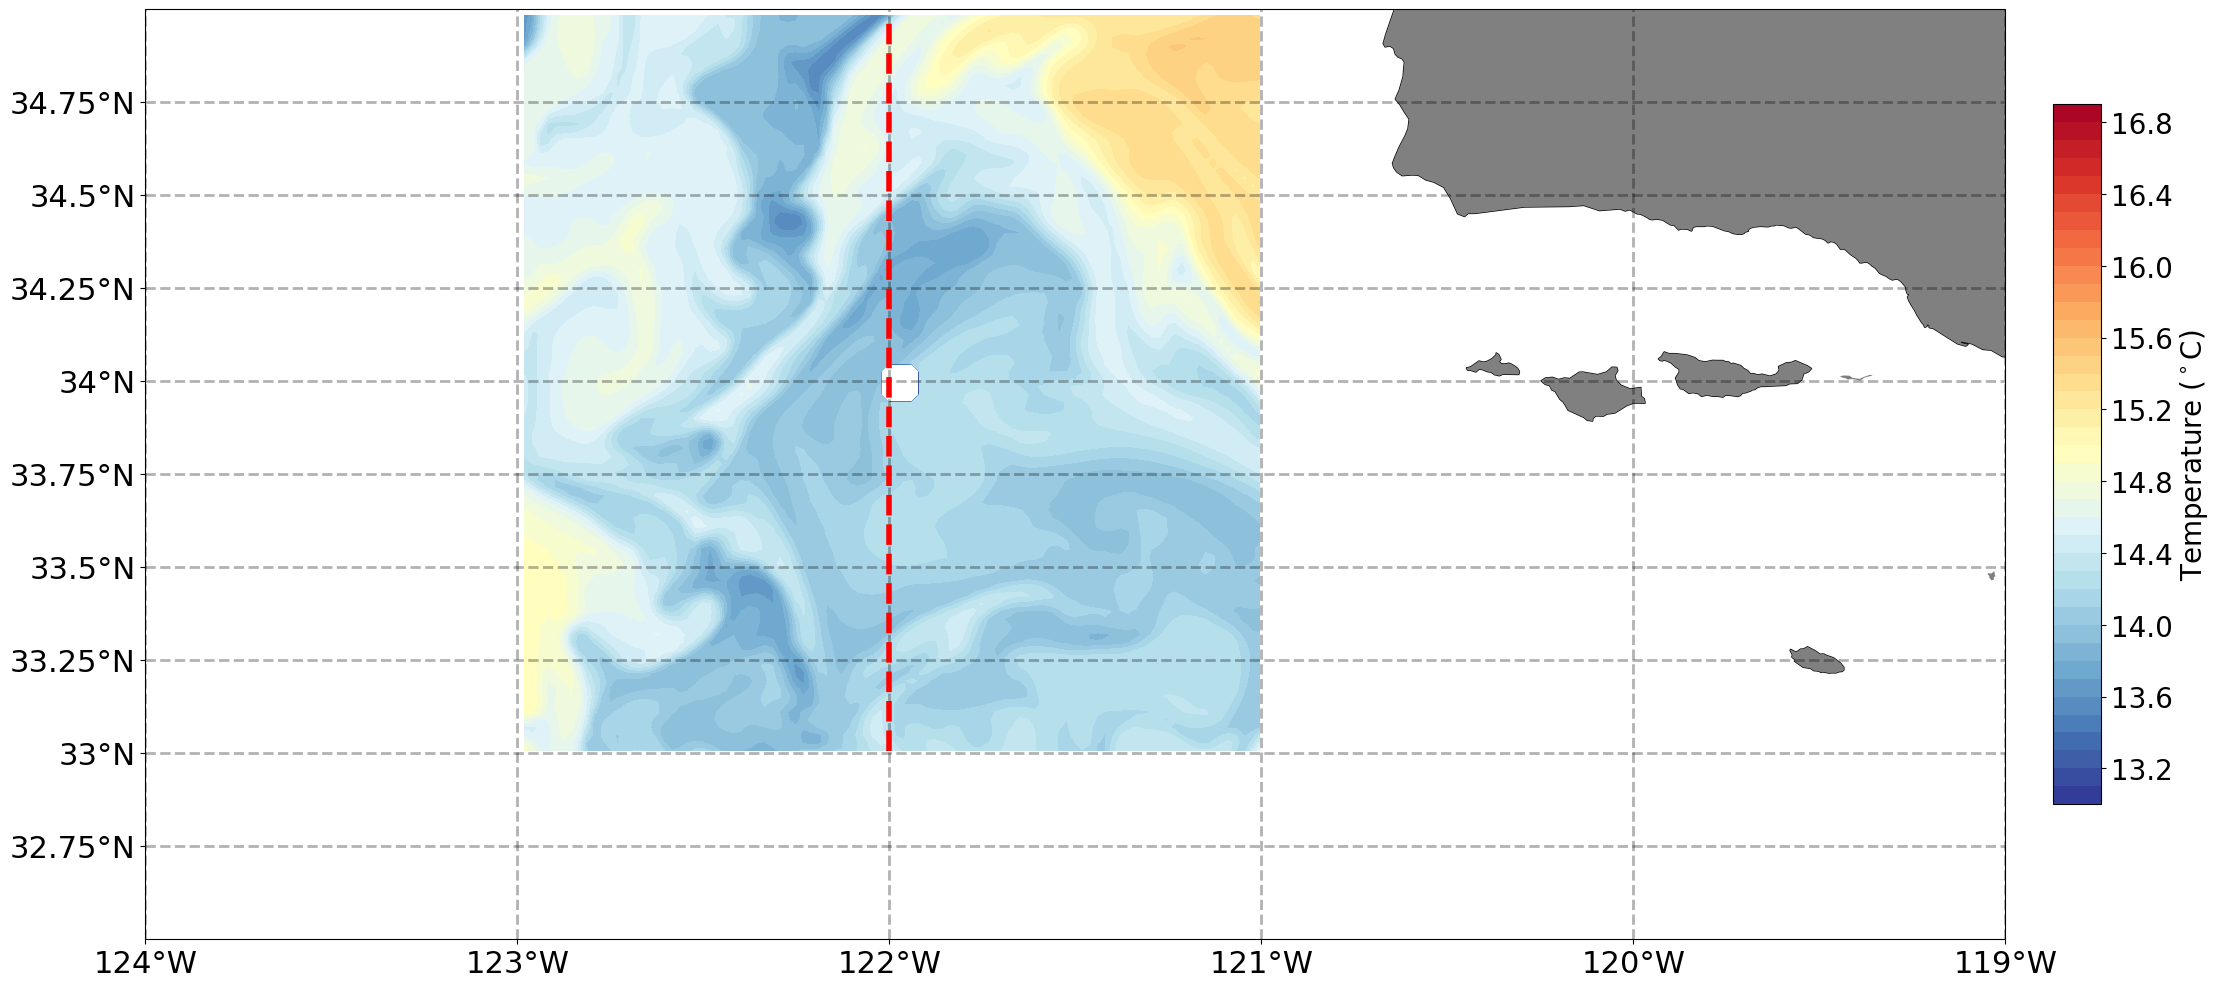

In [ ]:
# Set plotting parameters
projection = ccrs.PlateCarree(central_longitude=0.0)
xticks = [-124, -123, -122, -121, -120, -119]
yticks = [32.75, 33.00, 33.25, 33.50, 33.75, 34.00, 34.25, 34.50, 34.75,]
resolution = "10m"
bounds = np.arange(0,360+40,40)
lon_min = -124
lon_max = -119
lat_min = 32.50
lat_max = 35

# Specify data specific attributes 
if option_var == 'temp':
    cmap = 'RdYlBu_r'
    label = r'Temperature ($^\circ$C)'
    levels = np.arange(13,17,0.1)
elif option_var == 'sal':
    cmap = 'BrBG_r'
    label = r'Salinity (psu)'
    levels = np.arange(32.85,33.75 + 0.02,0.02)
elif option_var == 'density': 
    cmap = 'Spectral_r'
    label = r'$\sigma_0$ (kg m$^{-3}$)'
    levels = np.arange(32.85,33.75 + 0.02,0.02)

# Create figure
fig, axes = plt.subplots(1,1, figsize=(24, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=-124, lon_max=-119, lat_min=32.50, lat_max=35) 

# Plot potential temperature
mesh = axes.contourf(
    lon, lat, data[1,:,:], levels=levels,
    transform=ccrs.PlateCarree(),
    cmap=cmap,  
    shading="auto"
)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="neither",
    cbar_label=label,
    nbins=10,
    fontsize=20,
    cbar_ticks=[],
    task="regular",
)

# Plot the 
axes.plot(lon_point*np.ones((96,)), lat, transform=ccrs.PlateCarree(), 
          color='red', markersize=20, markerfacecolor='none',
          markeredgecolor='red', markeredgewidth=6)

# Show the plot
plt.show()

Plot the temporal domain

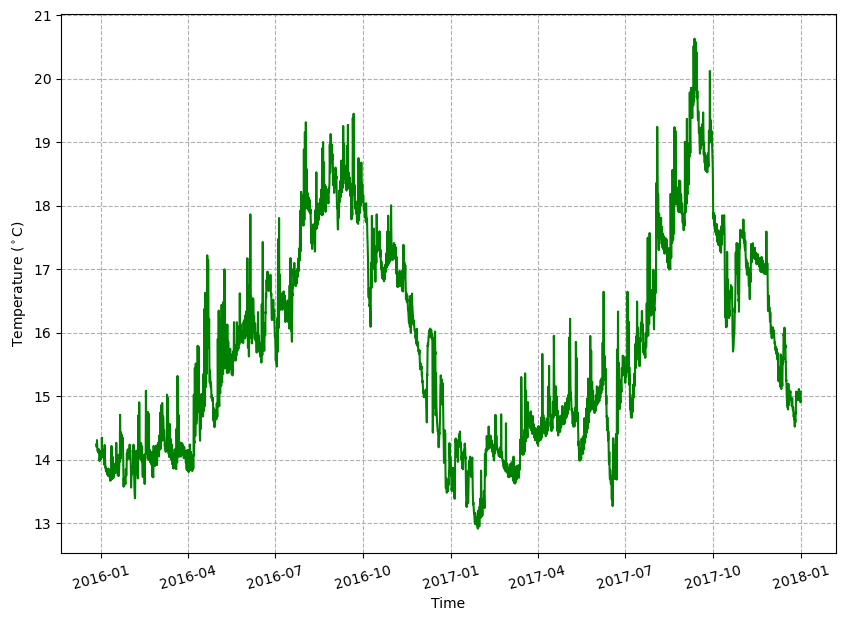

In [7]:
# Create figure
fig, axes = plt.subplots(1,1, figsize=(10, 7))

# Plot the time series of temperature
plt.plot(time_dt,data_ts,color='g',linestyle='-')

# Set the figure attributes 
plt.xlabel('Time')
plt.ylabel(label)
plt.xticks(rotation=15)
plt.grid(True, linestyle='--')
plt.show()

Preform scale analysis

In [8]:
# Set parameters
lag_off = len(data_ts)
    
# Convert to seconds since start time
t0 = time_dt[0]
time_elapsed = np.array([(t - t0).total_seconds() for t in time_dt])

# Initialize arrays 
autocorr_off = np.zeros((len(time),4,4))
time_scale_off = np.zeros((len(time),4,4))
L_off = np.zeros((4,4))
cn_lon = 0 

# Loop through a square of time series surrounding the longitude and latitude point
for ilon in range(idx_lon-1,idx_lon+3):

    # Set latitude counter 
    cn_lat = 0

    for ilat in range(idx_lat-1,idx_lat+3):
        
        # Initialize the ith time series 
        data_ts = data[:,ilon,ilat]

        # Compute autocorrelation function
        autocorr_off[:,cn_lon,cn_lat], _, _, _, time_scale_off[:,cn_lon,cn_lat], _ = compute_autocorr(data_ts, time_elapsed, lag_off, estimator, 0)

        # Compute the decorrelation scale
        L_off[cn_lon,cn_lat]   = compute_decor_scale(autocorr_off[:,cn_lon,cn_lat],time_scale_off[:,cn_lon,cn_lat],T,estimator,0)

        # Set latitude counter
        cn_lat = cn_lat + 1

    # Set longitude counter
    cn_lon = cn_lon + 1

# Convert time scale to units of months
L_off_s = L_off*(1/60)*(1/60)*(1/24)*(1/30)

Compute the mean autocorrelation function and its uncertainty

In [9]:
# Set the total number of time series we are averaging
N = 4 * 4 

# Compute the spatial average and standard deviation 
meanAutocorr_off = np.mean(autocorr_off, axis=(1, 2))
stdmAutocorr_off = np.std(autocorr_off, axis=(1, 2), ddof=1) / np.sqrt(N)

# Compute the mean time scale 
time_scale_off_m = np.mean(time_scale_off, axis=(1, 2))

#--- Off-shelf ---# 

# Compute the decorrelation scale 
L_off_m = compute_decor_scale(meanAutocorr_off,time_scale_off_m,T,estimator,0)

# Estimate the decorrelation scale's uncertainty by perturbing the autocorrelation function by 1 standard deviation
L_off_ustd = compute_decor_scale(meanAutocorr_off + stdmAutocorr_off,time_scale_off_m,T,estimator,0)
L_off_lstd = compute_decor_scale(meanAutocorr_off - stdmAutocorr_off,time_scale_off_m,T,estimator,0)

# Compute the average standard error 
std_upper = L_off_ustd - L_off
std_lower = abs(L_off_lstd - L_off)
L_on_stdm = np.mean([std_upper, std_lower])

# Convert time scale to units of months
T_off   = time_scale_off_m*(1/60)*(1/60)*(1/24)*(1/30)
L_off_ms = L_off_m*(1/60)*(1/60)*(1/24)*(1/30)
L_off_stdms = L_on_stdm*(1/60)*(1/60)*(1/24)*(1/30)


Plot the autocorrelation function

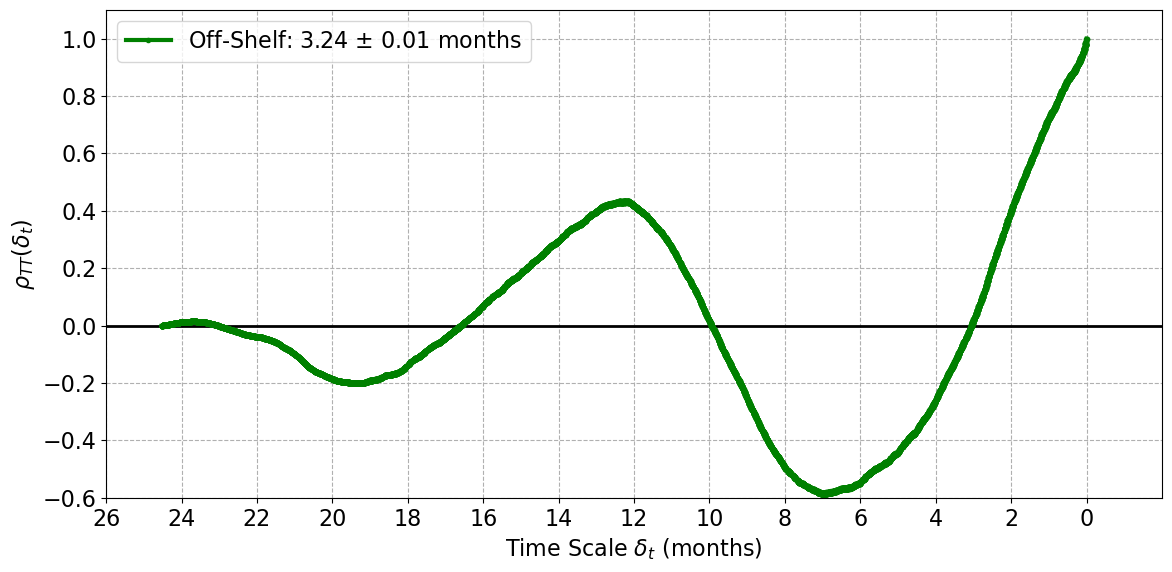

In [10]:
# Set plotting parameters
if option_var == 'temp':
    ylabel = r'$\rho_{TT} (\delta_t)$'
elif option_var == 'sal':
    ylabel = r'$\rho_{SS} (\delta_t)$'
elif option_var == 'density': 
    ylabel = r'$\rho_{\sigma\sigma} (\delta_t)$'

# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Create figure 

# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Create figure 
fig = plt.figure(figsize=(12, 6))

# Plot the zero crossing line
plt.axhline(0, color='k', linestyle='-', linewidth=2)

# Plot the mean autocorrelation functions 
plt.plot(T_off,meanAutocorr_off, 'g.-', linewidth=3, label=r'Off-Shelf: ' + str(np.round(L_off_ms,2)) + r' $\pm$ ' + str(np.round(L_off_stdms,2)) + ' months')

# Plot the error bars of the mean autocorrelation function 
plt.fill_between(T_off,meanAutocorr_off - stdmAutocorr_off,meanAutocorr_off + stdmAutocorr_off,color="tab:green",alpha=0.3)

# Set axis attributes
plt.xlabel(r"Time Scale $\delta_t$ (months)")
plt.ylabel(ylabel)
plt.xlim(-2,25)
plt.ylim(-0.6,1.1)
plt.xticks(np.arange(0,26+2,2))
plt.grid(True,linestyle='--')
plt.legend(loc="upper left")

# Reverse the direction of the x-axis 
plt.gca().invert_xaxis() 

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH_figs + 'autocorr_' + estimator, bbox_inches = 'tight', dpi=300)


In [11]:
111 + 111

222